In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [94]:
KLKB1 = pd.read_csv('../dumps/KLKB1_processed.csv')
ST14 = pd.read_csv('../dumps/ST14_processed.csv')
TMPRSS6 = pd.read_csv('../dumps/TMPRSS6_processed.csv')
TMPRSS11D = pd.read_csv('../dumps/TMPRSS11D_processed.csv')

TMPRSS2 = pd.read_csv('../dumps/TMPRSS2_processed.csv')
pubchem_datasets = {'KLKB1':     KLKB1,
                    'ST13':      ST14,
                    'TMPRSS6':   TMPRSS6,
                    'TMPRSS11D': TMPRSS11D}

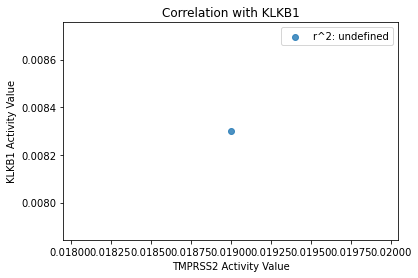

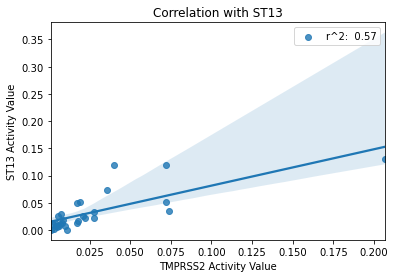

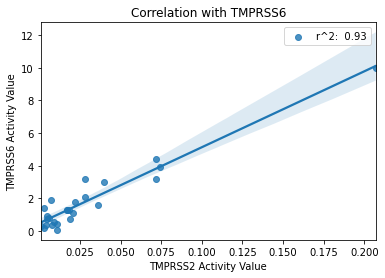

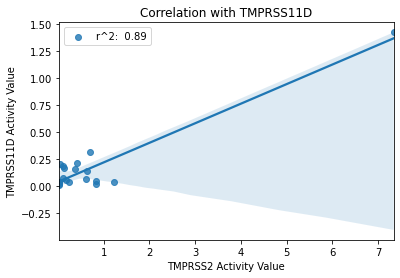

In [103]:
for name, pb_dataset in pubchem_datasets.items():
    plt.figure()
    overlap = pd.merge(TMPRSS2, pb_dataset, on=['cid', 'smiles'])
    x = overlap['acvalue_x']
    y = overlap['acvalue_y']
    try:
        sns.regplot(x, y, label=f'r^2: {pearsonr(x, y)[0]**2: .2f}')
    except ValueError:
        sns.regplot(x, y, label=f'r^2: undefined')
    plt.legend()
    plt.xlabel('TMPRSS2 Activity Value')
    plt.ylabel(f'{name} Activity Value')
    plt.title(f'Correlation with {name}')


I'm a bit concerned about the relative scale of the axes.  Although activity values are correlated, they're pretty bad absolute predictors.  Let's do the same plot with equal axes:

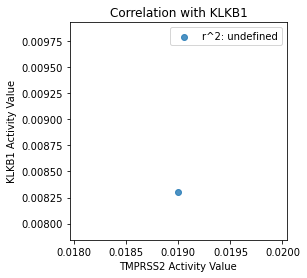

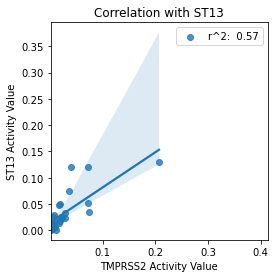

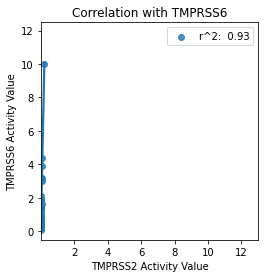

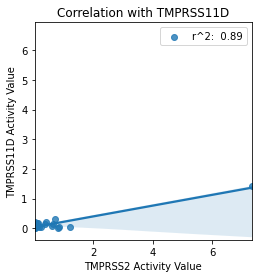

In [113]:
for name, pb_dataset in pubchem_datasets.items():
    plt.figure()
    overlap = pd.merge(TMPRSS2, pb_dataset, on=['cid', 'smiles'])
    x = overlap['acvalue_x']
    y = overlap['acvalue_y']
    try:
        sns.regplot(x, y, label=f'r^2: {pearsonr(x, y)[0]**2: .2f}')
    except ValueError:
        sns.regplot(x, y, label=f'r^2: undefined')
    plt.legend()
    plt.xlabel('TMPRSS2 Activity Value')
    plt.ylabel(f'{name} Activity Value')
    plt.title(f'Correlation with {name}')
    # equal axes
    plt.axis('square')

So as we can see, it's kind of problematic to just toss all the datasets together because of this scaling difference.  Perhaps we ought to use the linear regressions to transfrom the activity values such that the regression has slope 1.  Then, the correlation is indicating a prediction.  Let's try that:

/opt/miniconda3/envs/tmprss2/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/opt/miniconda3/envs/tmprss2/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/miniconda3/envs/tmprss2/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


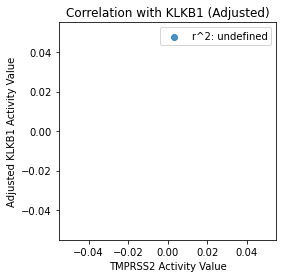

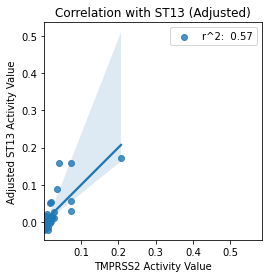

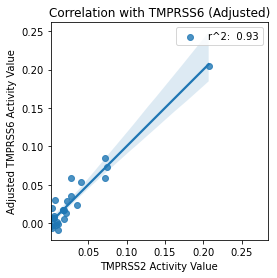

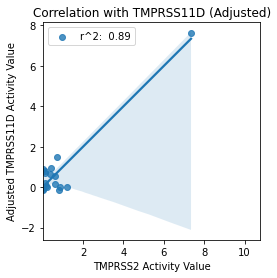

In [115]:
for name, pb_dataset in pubchem_datasets.items():
    overlap = pd.merge(TMPRSS2, pb_dataset, on=['cid', 'smiles'])
    x = overlap['acvalue_x']
    y = overlap['acvalue_y']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    y_adjusted = (y-intercept)/slope
    
    plt.figure()
    try:
        sns.regplot(x, y_adjusted, label=f'r^2: {pearsonr(x, y_adjusted)[0]**2: .2f}')
    except ValueError:
        sns.regplot(x, y_adjusted, label=f'r^2: undefined')
    plt.legend()
    plt.xlabel('TMPRSS2 Activity Value')
    plt.ylabel(f'Adjusted {name} Activity Value')
    plt.title(f'Correlation with {name} (Adjusted)')
    # equal axes
    plt.axis('square')

Kind of a bold data transformation, but you can see the r^2 values are unchanged; it's just a scaling.  Now, we have a way to level the playing field between the datasets, and incorporate them together: scale the values based on the predicted linear regression, then weight them based on how strong the correlation was (this proxies the "quality" of the transformed data).  How exactly to "weight" will be model dependent, I think.